# Preliminary

"""
import pyuac

def main():
    print("Do stuff here that requires being run as an admin.")
    # The window will disappear as soon as the program exits!
    input("Press enter to close the window. >")

if __name__ == "__main__":
    if not pyuac.isUserAdmin():
        print("Re-launching as admin!")
        pyuac.runAsAdmin()
    else:        
        main()
"""

In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer

import numpy as np
from scipy.special import softmax
import csv
import shutil
import matplotlib.pyplot as plt
from matplotlib import font_manager
from sklearn.metrics import confusion_matrix
import pandas as pd

In [2]:
tasks = ['emotion', 'hate', 'irony', 'offensive', 'sentiment-latest']

# Process Function

In [3]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [4]:
def get_labels(task):
    # download label mapping
    labels=[]
    mapping_link = f"./cardiffnlp/twitter-roberta-base-{task}/mapping.txt"
    with open(mapping_link, encoding="utf-8") as f:
        maps = f.read().split("\n")
        csvreader = csv.reader(maps, delimiter='\t')
    labels = [row[1] for row in csvreader if len(row) > 1]
    return labels

In [5]:
def get_analysis(task, text):
    labels = get_labels(task)
    MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    
    text = preprocess(text)
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    
    ranking = np.argsort(scores)
    ranking = ranking[::-1]
    print(f"According to our {task} model, this tweet is :")

    for i in range(scores.shape[0]):
        l = labels[ranking[i]]
        s = scores[ranking[i]]
        print(f"{i+1}) {l} {np.round(float(s), 4)}")
    
    return scores

# Let's Analyse

In [6]:
tweet = "My IA teacher is so handsome !"

for task in tasks:
    get_analysis(task, tweet)

According to our emotion model, this tweet is :
1) joy 0.9542
2) optimism 0.0177
3) anger 0.0145
4) sadness 0.0136
According to our hate model, this tweet is :
1) not-hate 0.9523
2) hate 0.0477
According to our irony model, this tweet is :
1) irony 0.9348
2) non_irony 0.0652
According to our offensive model, this tweet is :
1) not-offensive 0.8711
2) offensive 0.1289
According to our sentiment-latest model, this tweet is :
1) positive 0.9868
2) neutral 0.009
3) negative 0.0042


In [7]:
def prediction(task, text):
    MODEL = f"cardiffnlp/twitter-roberta-base-{task}"
    tokenizer = AutoTokenizer.from_pretrained(MODEL)
    model = AutoModelForSequenceClassification.from_pretrained(MODEL)
    
    encoded_input = tokenizer(text, return_tensors='pt')
    output = model(**encoded_input)
    label = output[0][0].detach().numpy().argmax(axis = 0)
    
    return label

#task = "sentiment"
#print(get_labels(task))

#label = prediction("sentiment", "My IA teacher is handsome")
#print(label)

In [8]:
pred_label = prediction("sentiment", "My IA teacher is handsome")
print(pred_label)

2


In [9]:
#from sklearn.metrics import confusion_matrix
#import matplotlib.pyplot as plt
#import matplotlib.font_manager as fm

# Load the font file
#font_path = "./font/NotoEmoji-VariableFont_wght.ttf"
#font_prop = fm.FontProperties(fname=font_path)
#plt.rcParams["font.family"] = font_prop.get_name()
#import os
#print(os.path.isfile(font_path))z
#if task == "emoji":
#    font_path = "font/NotoEmoji-Regular.ttf"
#    prop = font_manager.FontProperties(fname=font_path)
#    legend_labels = ['read hearth', '😍', '😂', '💕', '🔥', '😊', '😎', '✨', 'blue hearth', '😘', '📷', 'US flag', '☀', 'purple hearth', '😉', '💯', '😁', '🎄', '📸', '😜']


In [10]:
def display_confusion_matrix(conf_mat, list_labels, order_labels, task = "", data_set= "", nb_samples=10):
    plt.imshow(conf_mat, cmap='YlOrRd')
    #plt.plot(conf_mat, cmap='YlOrRd')
    plt.colorbar()
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')

    for i in range(len(conf_mat)):
        for j in range(len(conf_mat[i])):
            if i == j:
                plt.text(j, i, int(round(conf_mat[i][j] * 100)), ha="center", va="center", color="white")
            else:
                plt.text(j, i, int(round(conf_mat[i][j] * 100)), ha='center', va='center', color='black')

    plt.xticks(order_labels)
    plt.yticks(order_labels)
    
    plt.gca().set_xticklabels(list_labels, rotation=90)
    plt.gca().set_yticklabels(list_labels)

    #plt.title("+ de 25% du temps de travail a été à dessiner ce graph, profitez-en")
    plt.title(f"Confusion Matrix of the {task} model")
    #plt.savefig(f"error_analysis/confusion_matrix_{task}_{data_set}_{nb_samples}.png",dpi=300)
    #if(display == "no"):
    #    plt.close()
        
    return plt

In [11]:
def error_by_class_calculation(true_labels, pred_labels, order_labels):
    conf_mat = confusion_matrix(true_labels, pred_labels, labels=order_labels)
    wrong_class_prop = np.zeros((1, len(order_labels)))
    sum_of_error = conf_mat.sum() - np.trace(conf_mat)
    for i in range(len(conf_mat)):
        wrong_class_prop[0, i] = (conf_mat[i, :].sum() - conf_mat[i, i]) / sum_of_error if sum_of_error != 0 else 0
        
    return wrong_class_prop

In [12]:
def display_error_by_class(wrong_class_prop, list_labels, task = "", data_set= "", nb_samples=10):
    (fig, ax) = plt.subplots(figsize=(7, 4))
    plt.plot(range(len(list_labels)), wrong_class_prop[0], marker = 'o')
    
    y_axes = [(i/10) for i in range(6)]
    ax.set_yticks(y_axes)

    
    plt.xticks(np.arange(len(list_labels)))
    plt.gca().set_xticklabels(list_labels, rotation=90)
    plt.xlabel('Predicted labels')
    plt.ylabel('Portion of wrong label')
    plt.title("Proportion of wrongly labeled text among the wrong labeled texts")
    #plt.savefig(f"error_analysis/error_by_class_{task}_{data_set}_{nb_samples}.png",dpi=300)
    #if(display == "no"):
    #    plt.close()
        
    return plt

In [13]:
def error_analysis(text_dataset, true_labels, task, data_set,  nb_samples=10, display="no"):
    pred_labels = []
    text_dataset = text_dataset[:nb_samples]
    true_labels = true_labels[:nb_samples]
    list_labels = get_labels(task)
    order_labels = np.arange(len(list_labels))
    
    i = 0
    for text in text_dataset:
        i+=1
        print(f"sample number {i}")
        pred_label = prediction(task, text)
        pred_labels.append(pred_label)

    pred_labels = np.array(pred_labels).flatten()
    true_labels = np.array(true_labels).flatten()
    
    conf_mat = confusion_matrix(true_labels, pred_labels, labels=order_labels, normalize='true')
    plt_confusion = display_confusion_matrix(conf_mat, list_labels, order_labels, task, data_set, nb_samples)
    plt_confusion.savefig(f"error_analysis/confusion_matrix_{task}_{data_set}_{nb_samples}.png",dpi=300)
    if(display == "no"):
        plt_confusion.close()

    wrong_class_prop = error_by_class_calculation(true_labels, pred_labels, order_labels)
    plt_error = display_error_by_class(wrong_class_prop, list_labels, task, data_set, nb_samples)
    plt_error.savefig(f"error_analysis/error_by_class_{task}_{data_set}_{nb_samples}.png",dpi=300)
    if(display == "no"):
        plt_error.close()

    

In [14]:
def error_analysis_specific_set(task, data_set, nb_sample=10, display="no"):
    df_data = pd.read_parquet(f"./data_set/{task}/tweet_eval-{data_set}.parquet")
    
    
    texts = df_data['text'][:nb_sample].tolist()
    labels = df_data['label'][:nb_sample].tolist()
    print("   current data_set =", data_set) 
    error_analysis(texts, labels, task, data_set, nb_samples = nb_sample, display=display)

   current data_set = test
sample number 1
sample number 2


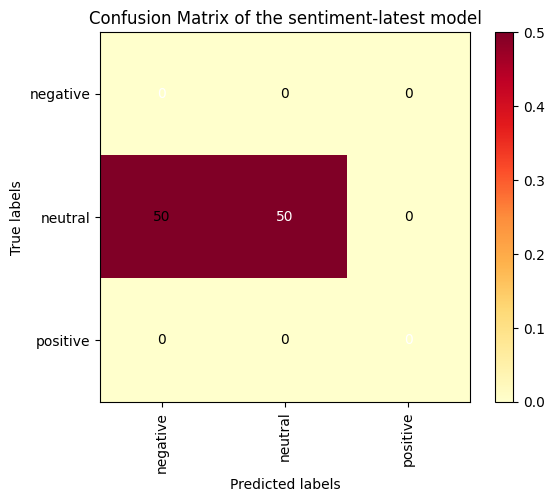

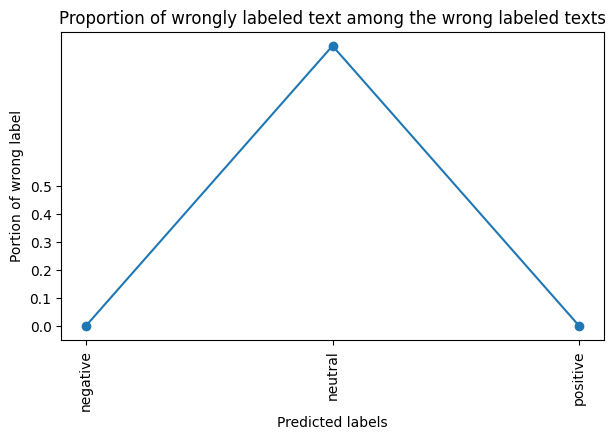

In [15]:
error_analysis_specific_set("sentiment-latest", "test", nb_sample=2, display="yes")  

In [19]:
# à faire tourner si on a le temps :)
for task in tasks:
    print("task =", task)
    for data_set in ["test", "train", "validation"]:
        error_analysis_specific_set(task, data_set, nb_sample=2, display="no")  # à faire quand on aura le temps
    print("")

task = emotion
   current data_set = test
sample number 1
sample number 2
   current data_set = train
sample number 1
sample number 2
   current data_set = validation
sample number 1
sample number 2

task = hate
   current data_set = test
sample number 1
sample number 2


KeyboardInterrupt: 